# Medical Compliance Forcasting

Predict if patient will Adhere to Prescription or not

In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")

import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import train_test_split
from imblearn.ensemble import BalanceCascade

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import cross_val_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.cross_validation import KFold
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier

from sklearn.metrics import classification_report, accuracy_score

### Read data

In [2]:
data = pd.read_csv('TrainingData.csv')

#### Lets see how data looks like

In [3]:
data.head(1)

,patient_id,Age,Gender,Prescription_period,Diabetes,Alcoholism,HyperTension,Smokes,Tuberculosis,Sms_Reminder,Adherence
0,1,19,M,7,0,0,0,0,0,0,No


In [4]:
data['Adherence'].value_counts()

No     125822
Yes     54390
Name: Adherence, dtype: int64

In [5]:
125822/(125822+54390)

0.6981887998579451

70:30 class ratio - might lead to imbalance

In [9]:
data.shape

(180212, 11)

In [10]:
data.dtypes

patient_id              int64
Age                     int64
Gender                 object
Prescription_period     int64
Diabetes                int64
Alcoholism              int64
HyperTension            int64
Smokes                  int64
Tuberculosis            int64
Sms_Reminder            int64
Adherence              object
dtype: object

In [11]:
data.describe()

,patient_id,Age,Prescription_period,Diabetes,Alcoholism,HyperTension,Smokes,Tuberculosis,Sms_Reminder
count,180212.000000,180212.000000,180212.000000,180212.000000,180212.000000,180212.000000,180212.000000,180212.000000,180212.000000
mean,90106.500000,37.795363,54.668485,0.078524,0.025043,0.216512,0.052566,0.000338,0.573968
std,52022.867693,22.852072,35.752491,0.268995,0.156255,0.411868,0.223166,0.018395,0.499824
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,45053.750000,19.000000,22.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,90106.500000,38.000000,51.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,135159.250000,56.000000,86.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,180212.000000,113.000000,120.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000


In [12]:
unique_count = []
for i in data.columns:
    unique_count.append([i,len(data[i].unique()),data[i].isnull().sum()])

In [13]:
pd.DataFrame(unique_count, columns=["Column","Unique","Missing"]).set_index("Column").T

Column,patient_id,Age,Gender,Prescription_period,Diabetes,Alcoholism,HyperTension,Smokes,Tuberculosis,Sms_Reminder,Adherence
Unique,180212,107,2,120,2,2,2,2,2,3,2
Missing,0,0,0,0,0,0,0,0,0,0,0


In [14]:
y = data.Adherence

There are no missing values in data set, so imputation is not required

In [15]:
data.Age.unique()

array([ 19,  24,   4,  38,  46,  20,  51,  58,  73,  48,  64,   5,  16,
         7,  29,  59,   8,  27,  37,   9,  25,  57,  78,  41,  95,   0,
        34,  44,   1,  67,  63,  35,  28,  77,  23,  13,  80,  39,  61,
        55,  54,  60,  42,  21,  52,  65,  15,  53,  50,  36,  69,  62,
        18,  14,  32,  17,  76,  43,  31,  30,  33,  22,  10,  49,  81,
        75,  26,  45,   6,  70,  66,   2,  84,   3,  56,  11,  71,  82,
        40,  85,  12,  74,  68,  47,  88,  79,  83,  72,  86,  93,  89,
        94,  91,  87, 104,  96,  92,  90, 101,  98, 103, 100,  97,  99,
       113, 108, 102])

In [16]:
data.corr()

,patient_id,Age,Prescription_period,Diabetes,Alcoholism,HyperTension,Smokes,Tuberculosis,Sms_Reminder
patient_id,1.000000,0.000386,0.000724,0.000260,0.001969,0.003887,-0.003523,0.003778,0.002661
Age,0.000386,1.000000,0.061055,0.295050,0.071761,0.509416,0.090797,0.001300,-0.051713
Prescription_period,0.000724,0.061055,1.000000,0.017072,-0.015018,0.035913,-0.016020,-0.001677,0.001959
Diabetes,0.000260,0.295050,0.017072,1.000000,0.021997,0.423884,0.041240,0.004721,-0.031252
Alcoholism,0.001969,0.071761,-0.015018,0.021997,1.000000,0.068796,0.390472,0.045315,-0.017998
HyperTension,0.003887,0.509416,0.035913,0.423884,0.068796,1.000000,0.077154,-0.001617,-0.043751
Smokes,-0.003523,0.090797,-0.016020,0.041240,0.390472,0.077154,1.000000,0.021349,-0.011701
Tuberculosis,0.003778,0.001300,-0.001677,0.004721,0.045315,-0.001617,0.021349,1.000000,-0.006043
Sms_Reminder,0.002661,-0.051713,0.001959,-0.031252,-0.017998,-0.043751,-0.011701,-0.006043,1.000000


Check corr in Age vs Prescription_period

In [18]:
from scipy.stats.stats import pearsonr   
pearsonr(data.Age, data.Prescription_period)

(0.061054820207031374, 2.2015646254229287e-148)

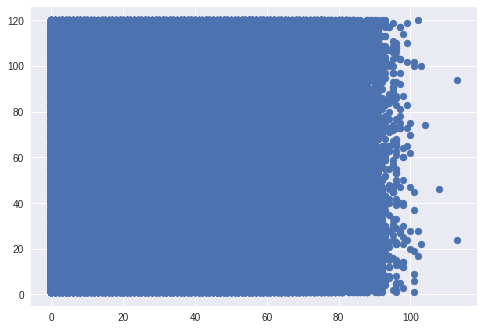

In [19]:
plt.scatter(data.Age, data.Prescription_period)
plt.show()

##### There is no correlation between Age and Prescription_period

Let's see how Age is distributed

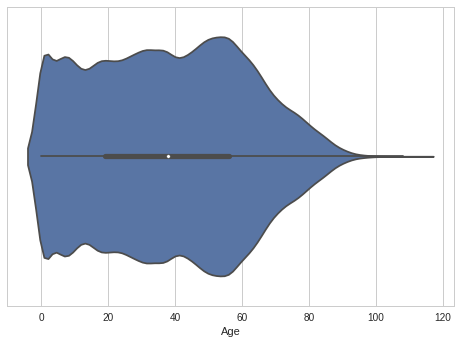

In [20]:
sns.set(style="whitegrid")
tips = sns.load_dataset("tips")
ax = sns.violinplot(x=data['Age'])

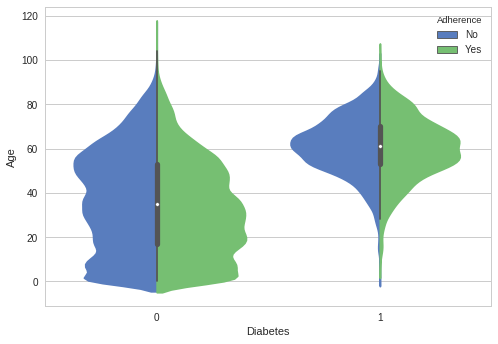

In [21]:
ax = sns.violinplot(x="Diabetes", y="Age", hue="Adherence", data=data, palette="muted", split=True)

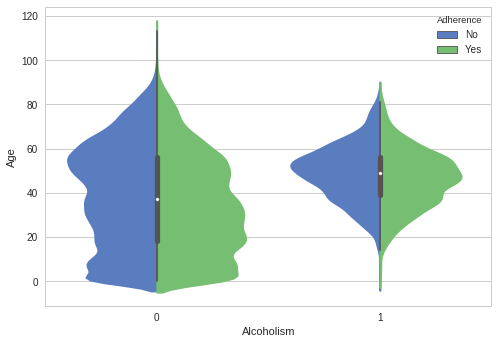

In [22]:
ax = sns.violinplot(x="Alcoholism", y="Age", hue="Adherence", data=data, palette="muted", split=True)

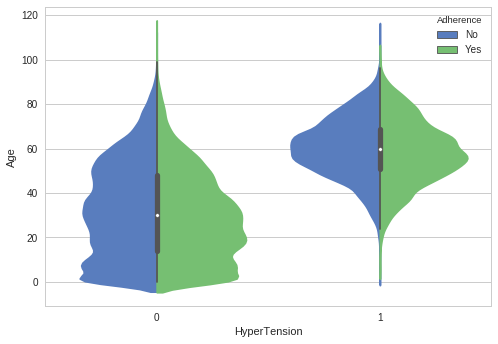

In [23]:
ax = sns.violinplot(x="HyperTension", y="Age", hue="Adherence", data=data, palette="muted", split=True)

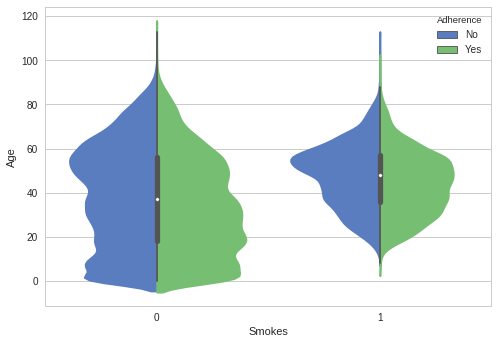

In [24]:
ax = sns.violinplot(x="Smokes", y="Age", hue="Adherence", data=data, palette="muted", split=True)

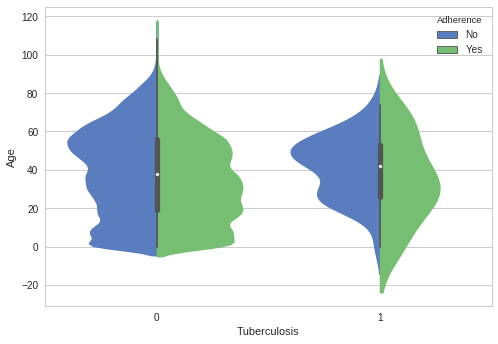

In [25]:
ax = sns.violinplot(x="Tuberculosis", y="Age", hue="Adherence", data=data, palette="muted", split=True)

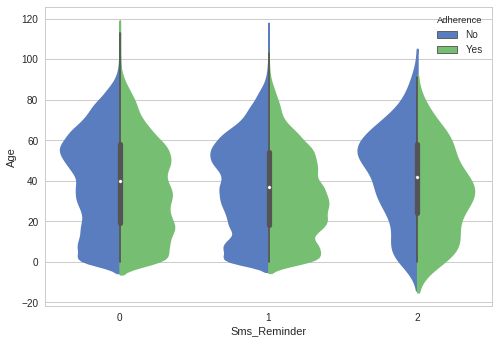

In [26]:
ax = sns.violinplot(x="Sms_Reminder", y="Age", hue="Adherence", data=data, palette="muted", split=True)

Categorical data exploration

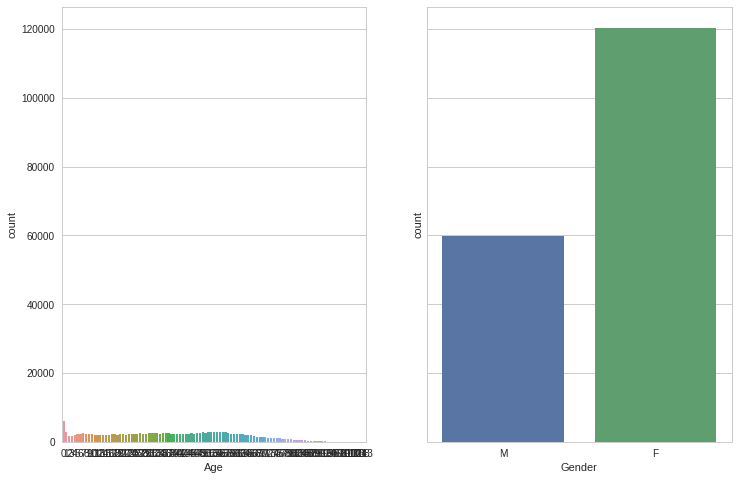

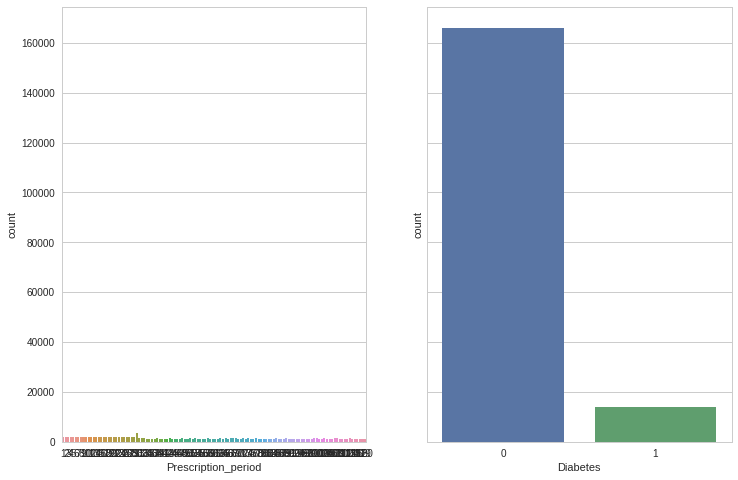

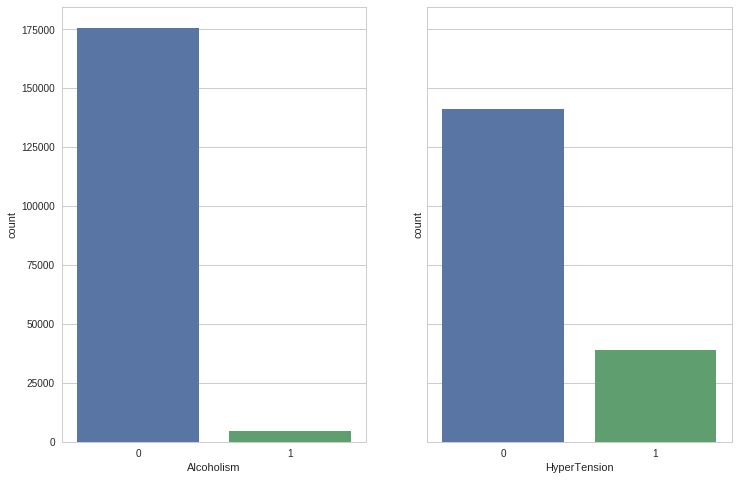

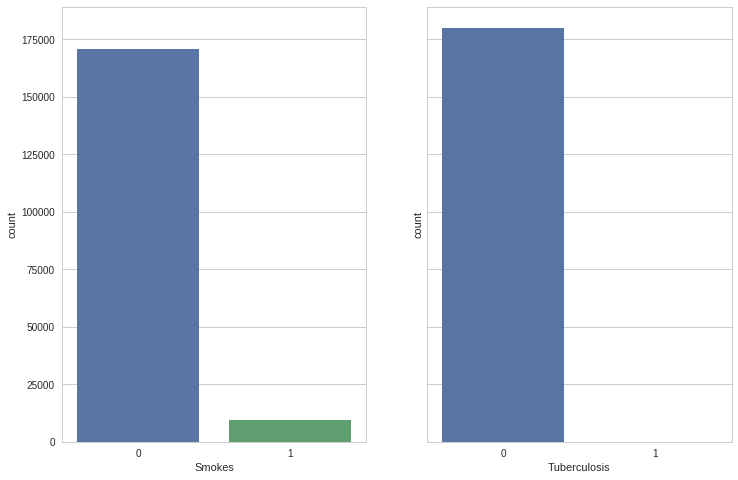

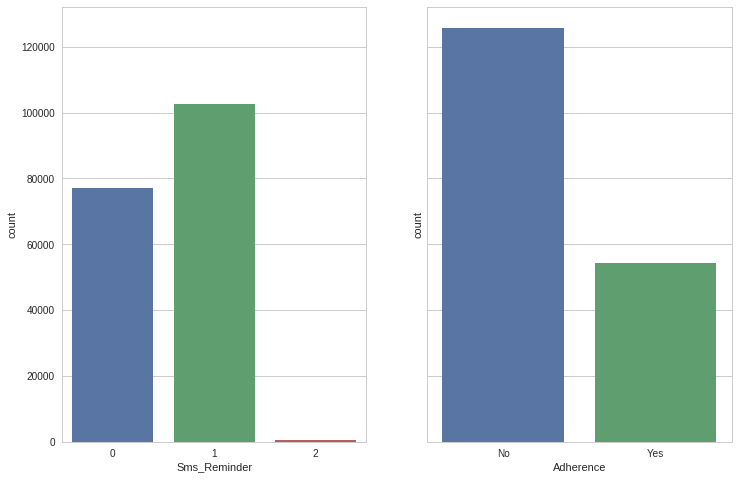

In [27]:
#Plot count plot for all attributes in a 29x4 grid
cols = data.columns[1:]
n_cols = 2
n_rows = 5
for i in range(n_rows):
    fg,ax = plt.subplots(nrows=1,ncols=n_cols,sharey=True,figsize=(12, 8))
    for j in range(n_cols):
        sns.countplot(x=cols[i*n_cols+j], data=data, ax=ax[j])

In [28]:
data.Prescription_period.unique()

array([  7,  59,  43,  66,  98,  73, 102,  96,  89,  97,  77, 107,   9,
       115,  35,  17,  31,  92,  44,  13,  21,   1,  69,  79, 119,  46,
        58,  19,  64,  18,  28,  14,  10,  23,   6,  99,  33,  39,   3,
        36,  24,  25,  30,  86,   4,  32,  75,  76, 101,  80, 108,  83,
        40,  93,   8,  57,  50,  54,  72,  55,  38,  56,  12,  47, 104,
        41,  26,  65, 118, 114,  70,  91, 117,  87, 106,  63, 105,  20,
        45, 113,  27, 111,  67, 116,  95, 100,  51,  74,  16,  34, 103,
        11,  90, 110,   5,   2,  84,  37, 112,  42, 120,  29, 109,  61,
        60,  53,  68,  49,  22,  94,  85,  15,  81,  78,  71,  62,  82,
        48,  88,  52])

### Data Transformation

Convert Prescription_period days to weeeks

In [30]:
data['Prescription_weeks'] = np.round(data.Prescription_period/7)
data.Prescription_weeks

0          1.0
1          8.0
2          6.0
3          9.0
4         14.0
5         10.0
6         15.0
7         14.0
8         13.0
9         14.0
10        11.0
11        15.0
12         1.0
13        16.0
14         5.0
15         2.0
16         4.0
17        13.0
18         6.0
19         2.0
20         6.0
21         3.0
22         0.0
23        10.0
24        11.0
25        17.0
26         7.0
27        17.0
28         8.0
29         8.0
          ... 
180182    17.0
180183    14.0
180184     3.0
180185     2.0
180186     8.0
180187    12.0
180188     3.0
180189     3.0
180190    17.0
180191     6.0
180192    14.0
180193     1.0
180194     6.0
180195     1.0
180196    15.0
180197    14.0
180198    15.0
180199     2.0
180200    13.0
180201     6.0
180202     3.0
180203    12.0
180204     4.0
180205     0.0
180206     0.0
180207    12.0
180208    13.0
180209     3.0
180210    15.0
180211    14.0
Name: Prescription_weeks, Length: 180212, dtype: float64

In [31]:
data.Age.unique()

array([ 19,  24,   4,  38,  46,  20,  51,  58,  73,  48,  64,   5,  16,
         7,  29,  59,   8,  27,  37,   9,  25,  57,  78,  41,  95,   0,
        34,  44,   1,  67,  63,  35,  28,  77,  23,  13,  80,  39,  61,
        55,  54,  60,  42,  21,  52,  65,  15,  53,  50,  36,  69,  62,
        18,  14,  32,  17,  76,  43,  31,  30,  33,  22,  10,  49,  81,
        75,  26,  45,   6,  70,  66,   2,  84,   3,  56,  11,  71,  82,
        40,  85,  12,  74,  68,  47,  88,  79,  83,  72,  86,  93,  89,
        94,  91,  87, 104,  96,  92,  90, 101,  98, 103, 100,  97,  99,
       113, 108, 102])

Convert Age to Infant id, Young, Middle-aged Senior, Old bins.

In [32]:
age_bins = [0, 5, 10, 25, 45, 65, 113]
age_labels = ["Infant", "Kid", "Young", "Middle-aged", "Senior", "Old"]
data['Age_bins'] = pd.cut(data['Age'], age_bins, labels=age_labels, 
    right=True, include_lowest=True)
data['Age_bins'][:5]

0          Young
1          Young
2         Infant
3    Middle-aged
4         Senior
Name: Age_bins, dtype: category
Categories (6, object): [Infant < Kid < Young < Middle-aged < Senior < Old]

In [33]:
for i in data.columns:
    le = LabelEncoder()
    data[i] = le.fit_transform(data[i])

In [34]:
data.dtypes

patient_id             int64
Age                    int64
Gender                 int64
Prescription_period    int64
Diabetes               int64
Alcoholism             int64
HyperTension           int64
Smokes                 int64
Tuberculosis           int64
Sms_Reminder           int64
Adherence              int64
Prescription_weeks     int64
Age_bins               int64
dtype: object

In [35]:
data.head()

,patient_id,Age,Gender,Prescription_period,Diabetes,Alcoholism,HyperTension,Smokes,Tuberculosis,Sms_Reminder,Adherence,Prescription_weeks,Age_bins
0,0,19,1,6,0,0,0,0,0,0,0,1,5
1,1,24,0,58,0,0,0,0,0,0,0,8,5
2,2,4,0,42,0,0,0,0,0,0,0,6,0
3,3,38,1,65,0,0,0,0,0,1,0,9,2
4,4,46,0,97,0,0,0,0,0,1,0,14,4


In [36]:
cat_var = [ 'Age_bins', 'Prescription_weeks', 'Diabetes', 'Alcoholism',
       'HyperTension', 'Smokes', 'Tuberculosis', 'Sms_Reminder', 'Adherence']
for i in cat_var:
    data[i] = pd.Categorical(data[i])

data.dtypes

patient_id                int64
Age                       int64
Gender                    int64
Prescription_period       int64
Diabetes               category
Alcoholism             category
HyperTension           category
Smokes                 category
Tuberculosis           category
Sms_Reminder           category
Adherence              category
Prescription_weeks     category
Age_bins               category
dtype: object

Generalized method to call classification model

In [37]:
def classification_model(model, data, predictors, outcome, test_):
    
    #fit model
    model.fit(data[predictors], data[outcome])
    
    #predict using model
    predictions = model.predict(data[predictors])
    
    #Print accuracy
    accuracy = metrics.accuracy_score(predictions, data[outcome])
    print(" Accuracy is", accuracy)
    
    # k-fold cross validation
    kf = KFold(data.shape[0], n_folds= 5)
    
    error =[]
    
    for train, test in kf:
        train_predictors = (data[predictors].iloc[train,:]) 
        train_target = (data[outcome].iloc[train])
        
        test_predictors = (data[predictors].iloc[test,:])
        test_target = (data[outcome].iloc[test])
        
        model.fit(train_predictors, train_target)
        
        #error on the test data from k-fold
        temp = model.score(test_predictors, test_target)
        
        error.append(temp)
    
    y_pred = model.predict_proba(test_[predictors])[:,1]
    threshold = 0.4 # You can play on this value (default is 0.5)
    y_pred = [1 if i >= threshold else 0 for i in y_pred]
    print(classification_report(test_[outcome], y_pred))    
    print("Cross validation score: %s"% np.mean(error))

### Logistic

In [38]:
predictor_var1 = ['Age', 'Gender', 'Prescription_period', 'Diabetes',
                 'Alcoholism', 'HyperTension', 'Smokes', 'Tuberculosis', 'Sms_Reminder']


predictor_var2 = ['Prescription_weeks', 'Age_bins', 'Gender',  'Diabetes',
                 'Alcoholism', 'HyperTension', 'Smokes', 'Tuberculosis', 'Sms_Reminder']

outcome = 'Adherence'

In [39]:
train, test, y_train, y_test = train_test_split(data, data[outcome], test_size=0.2)

In [40]:
logit_model = LogisticRegression()
classification_model(logit_model, train, predictor_var1, outcome, test)

 Accuracy is 0.880244712802
             precision    recall  f1-score   support

          0       0.95      0.86      0.90     25178
          1       0.73      0.90      0.81     10865

avg / total       0.88      0.87      0.87     36043

Cross validation score: 0.880258602371


In [42]:
logit_model = LogisticRegression()
classification_model(logit_model, train, predictor_var2, outcome, test)

 Accuracy is 0.883366049567
             precision    recall  f1-score   support

          0       0.95      0.87      0.91     25178
          1       0.75      0.90      0.82     10865

avg / total       0.89      0.88      0.88     36043

Cross validation score: 0.883435429904


In [43]:
dt_model = DecisionTreeClassifier()
classification_model(dt_model, train, predictor_var1,outcome, test)

 Accuracy is 0.92368678426
             precision    recall  f1-score   support

          0       0.91      0.87      0.89     25178
          1       0.73      0.81      0.77     10865

avg / total       0.86      0.85      0.85     36043

Cross validation score: 0.850182781395


In [44]:
dt_model = DecisionTreeClassifier()
classification_model(dt_model, train, predictor_var2,outcome, test)

 Accuracy is 0.88804111841
             precision    recall  f1-score   support

          0       0.95      0.88      0.91     25178
          1       0.76      0.90      0.82     10865

avg / total       0.89      0.88      0.89     36043

Cross validation score: 0.885280490789


In [45]:
rf_model1 = RandomForestClassifier()
classification_model(rf_model1, train, predictor_var1, outcome, test)

 Accuracy is 0.920232504907
             precision    recall  f1-score   support

          0       0.93      0.87      0.90     25178
          1       0.74      0.84      0.79     10865

avg / total       0.87      0.86      0.87     36043

Cross validation score: 0.863764062406


In [46]:
rf_model2 = RandomForestClassifier()
classification_model(rf_model2, train, predictor_var2, outcome, test)

 Accuracy is 0.887985627978
             precision    recall  f1-score   support

          0       0.95      0.88      0.91     25178
          1       0.76      0.90      0.82     10865

avg / total       0.89      0.88      0.89     36043

Cross validation score: 0.885412282536


Let's see which features are important

Random Forest - will give list of features and it's importance
PCA - will create all together new variables


In [47]:
featureImportance = pd.Series(rf_model1.feature_importances_, index= predictor_var1).sort_values(ascending = False)
print(featureImportance)

Prescription_period    0.846721
Age                    0.131118
Sms_Reminder           0.006539
Gender                 0.005475
HyperTension           0.003580
Diabetes               0.002662
Smokes                 0.002409
Alcoholism             0.001377
Tuberculosis           0.000119
dtype: float64


In [48]:
featureImportance = pd.Series(rf_model2.feature_importances_, index= predictor_var2).sort_values(ascending = False)
print(featureImportance)

Prescription_weeks    0.971227
Age_bins              0.013500
Sms_Reminder          0.004356
HyperTension          0.002881
Gender                0.002401
Smokes                0.002347
Alcoholism            0.001670
Diabetes              0.001456
Tuberculosis          0.000162
dtype: float64


It is clearly been seen that - Sms_Reminder , HyperTension, Diabetes, Smokes, Alcoholism, Tuberculosis have least importance

It is clear Age bin is not that important

So now let's try with important features

In [49]:
new_var = ['Prescription_period', 'Age']
rf_model = RandomForestClassifier()
classification_model(rf_model, train, new_var, outcome, test)

 Accuracy is 0.895830587713
             precision    recall  f1-score   support

          0       0.95      0.89      0.92     25178
          1       0.78      0.89      0.83     10865

avg / total       0.90      0.89      0.89     36043

Cross validation score: 0.889636484216


In [50]:
new_var = ['Prescription_period', 'Age', 'Gender']
rf_model = RandomForestClassifier()
classification_model(rf_model, train, new_var, outcome, test)

 Accuracy is 0.898209739958
             precision    recall  f1-score   support

          0       0.94      0.88      0.91     25178
          1       0.77      0.87      0.82     10865

avg / total       0.89      0.88      0.88     36043

Cross validation score: 0.881840083611


In [51]:
new_var = ['Prescription_weeks', 'Age', 'Gender']
rf_model = RandomForestClassifier()
classification_model(rf_model, train, new_var, outcome, test)

 Accuracy is 0.887534768223
             precision    recall  f1-score   support

          0       0.95      0.88      0.91     25178
          1       0.76      0.90      0.82     10865

avg / total       0.90      0.89      0.89     36043

Cross validation score: 0.885800713102


In [52]:
new_var = ['Prescription_weeks', 'Age_bins', 'Gender']
rf_model = RandomForestClassifier()
classification_model(rf_model, train, new_var, outcome, test)

 Accuracy is 0.887160207812
             precision    recall  f1-score   support

          0       0.95      0.88      0.91     25178
          1       0.76      0.90      0.83     10865

avg / total       0.90      0.89      0.89     36043

Cross validation score: 0.887160228382


In [53]:
new_var = ['Prescription_weeks', 'Age_bins']
rf_model = RandomForestClassifier()
classification_model(rf_model, train, new_var, outcome, test)

 Accuracy is 0.887160207812
             precision    recall  f1-score   support

          0       0.95      0.88      0.91     25178
          1       0.76      0.90      0.83     10865

avg / total       0.90      0.89      0.89     36043

Cross validation score: 0.887160228382


In [54]:
new_var = ['Prescription_weeks', 'Age']
rf_model = RandomForestClassifier()
classification_model(rf_model, train, new_var, outcome, test)

 Accuracy is 0.887271188674
             precision    recall  f1-score   support

          0       0.95      0.88      0.91     25178
          1       0.76      0.90      0.83     10865

avg / total       0.90      0.89      0.89     36043

Cross validation score: 0.886459663178


In [57]:
xgb_var = ['Prescription_period','Age']

model = XGBClassifier()
model.fit(train[xgb_var], train[outcome])
y_pred = model.predict(test[xgb_var])

accuracy = accuracy_score(test[outcome], y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print(classification_report(test[outcome], y_pred))

Accuracy: 89.42%
             precision    recall  f1-score   support

          0       0.95      0.90      0.92     25178
          1       0.79      0.89      0.83     10865

avg / total       0.90      0.89      0.90     36043



In [58]:
svm_model = SGDClassifier(n_iter=100, alpha=0.01) 
svm_model.fit(train[predictor_var1], train[outcome])
y_pred = svm_model.predict(test[predictor_var1])
print(classification_report(test[outcome], y_pred))

/home/sayali/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:73: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


             precision    recall  f1-score   support

          0       0.93      0.90      0.91     25178
          1       0.78      0.84      0.81     10865

avg / total       0.88      0.88      0.88     36043



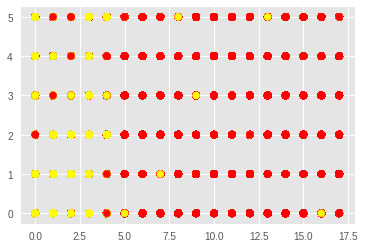

In [63]:
plt.scatter(data['Prescription_weeks'], data['Age_bins'], c=data['Adherence'], s=50, cmap='autumn');

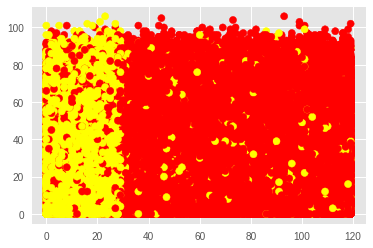

In [64]:
plt.scatter(data['Prescription_period'], data['Age'], c=data['Adherence'], s=50, cmap='autumn');

##### This is might land in imbalanced class problem

In [59]:
svm_model = SGDClassifier(n_iter=100, alpha=0.01, class_weight={1: 0.9}) # try with different class weight
svm_model.fit(train[predictor_var1], train[outcome])
y_pred = svm_model.predict(test[predictor_var1])
print(classification_report(test[outcome], y_pred))

/home/sayali/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:73: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


             precision    recall  f1-score   support

          0       0.94      0.87      0.91     25178
          1       0.75      0.88      0.81     10865

avg / total       0.89      0.88      0.88     36043



In [60]:
svm_model = SGDClassifier(n_iter=100, alpha=0.01, class_weight={1: 0.9}) 
svm_model.fit(train[new_var], train[outcome])
y_pred = svm_model.predict(test[new_var])
print(classification_report(test[outcome], y_pred))

/home/sayali/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:73: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


             precision    recall  f1-score   support

          0       0.95      0.89      0.91     25178
          1       0.77      0.88      0.82     10865

avg / total       0.89      0.88      0.89     36043



##### Though it is not high dimention problem we can try generate important features using PCA

In [65]:
from sklearn.decomposition import PCA
pca = PCA(n_components=9)
pca.fit(data[predictor_var1])

PCA(copy=True, iterated_power='auto', n_components=9, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [66]:
print(pca.components_)

[[  6.55578657e-02  -1.19126542e-04   9.97848517e-01   2.20662710e-04
   -5.22205983e-05   6.57146894e-04  -7.58389294e-05  -8.30929027e-07
   -2.96305640e-06]
 [  9.97797069e-01  -2.12009443e-03  -6.55614427e-02   3.46765138e-03
    5.03362729e-04   9.15477602e-03   9.06615458e-04   1.19011524e-06
   -1.14073228e-03]
 [  9.53975207e-04  -2.56948447e-01  -6.52025188e-05  -1.88440158e-02
   -1.42063488e-02  -3.45567385e-02  -1.18390249e-02  -3.00838468e-04
    9.65445619e-01]
 [  2.23199902e-03   9.64817446e-01  -3.05657984e-05   6.41271815e-03
    3.82459794e-02   4.39278223e-03   3.20340883e-02   3.15369585e-04
    2.58017162e-01]
 [ -9.83078630e-03  -1.83704435e-02  -4.42687221e-05   3.85456950e-01
    1.94379450e-02   9.20913482e-01   3.47885395e-02  -3.94307426e-05
    3.63194299e-02]
 [ -7.91501741e-04  -4.13825441e-02   1.38220213e-04  -3.58652967e-01
    3.67994616e-01   1.09343173e-01   8.49865826e-01   1.99484612e-03
    1.73775459e-03]
 [  4.25078087e-05  -2.16946447e-02   8.

In [67]:
print(pca.explained_variance_ratio_)

[  7.11467473e-01   2.88124964e-01   1.39662952e-04   1.20792999e-04
   7.67656189e-05   3.04817511e-05   2.94793211e-05   1.01921183e-05
   1.87444434e-07]


###### First 2 parameters explains around 99 % of variance

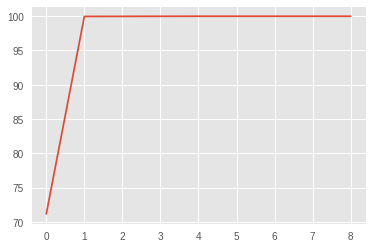

In [68]:
var1 = np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)
plt.plot(var1)

In [69]:
pca_X = pca.transform(data[predictor_var1])
pca_X.shape

(180212, 9)

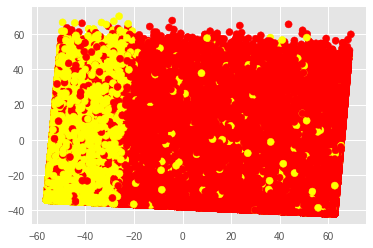

In [70]:
plt.scatter(pca_X[:, 0], pca_X[:, 1], c=data['Adherence'], s=50, cmap='autumn');

##### Try with transformed data

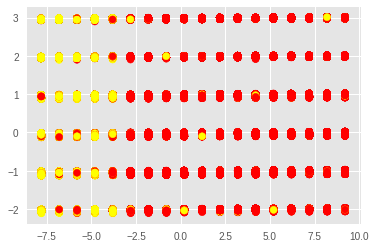

In [71]:
pca_bin = PCA(n_components=9)
pca_X_bin = pca_bin.fit_transform(data[predictor_var2])
plt.scatter(pca_X_bin[:, 0], pca_X_bin[:, 1], c=data['Adherence'], s=50, cmap='autumn');

In [72]:
train, test, y_train, y_test = train_test_split(pca_X_bin[:, 0:2], data['Adherence'], test_size=0.2)
svm_model = SGDClassifier(n_iter=100, alpha=0.01) 
svm_model.fit(train, y_train)
y_pred = svm_model.predict(test)
print(classification_report(y_test, y_pred))

/home/sayali/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:73: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


             precision    recall  f1-score   support

          0       0.95      0.88      0.92     25200
          1       0.77      0.90      0.83     10843

avg / total       0.90      0.89      0.89     36043



In [73]:
train, test, y_train, y_test = train_test_split(pca_X[:, 0:2], data['Adherence'], test_size=0.2)

In [74]:
svm_model = SGDClassifier(n_iter=100, alpha=0.01) 
svm_model.fit(train, y_train)
y_pred = svm_model.predict(test)
print(classification_report(y_test, y_pred))

/home/sayali/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:73: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


             precision    recall  f1-score   support

          0       0.88      0.93      0.90     25152
          1       0.80      0.70      0.74     10891

avg / total       0.85      0.86      0.85     36043



In [75]:
def plot_2d_space(X, y, label='Classes'):   
    colors = ['#1F77B4', '#FF7F0E']
    markers = ['o', 's']
    for l, c, m in zip(np.unique(y), colors, markers):
        plt.scatter(
            X[y==l, 0],
            X[y==l, 1],
            c=c, label=l, marker=m
        )
    plt.title(label)
    plt.legend(loc='upper right')
    plt.show()

## Sampling
For imbalanced Class

Removed indexes: [ 33645   1057   6058 ..., 144162 144164 144165]


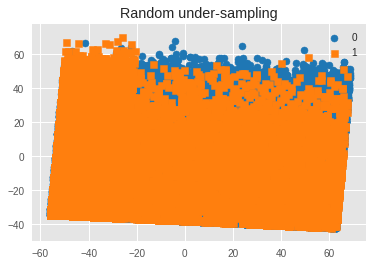

In [76]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(return_indices=True)
X_rus, y_rus, id_rus = rus.fit_sample(train, y_train)

print('Removed indexes:', id_rus)

plot_2d_space(X_rus, y_rus, 'Random under-sampling')

In [77]:
y_rus

array([0, 0, 0, ..., 1, 1, 1])

In [79]:
print(len([i for i in y_train if i == 0 ] ))
print(len([i for i in y_train if i == 1 ] ))
print(len([i for i in y_rus if i == 0 ] ))
print(len([i for i in y_rus if i == 1 ] ))

100670
43499
43499
43499


57171 new random picked points
100670
43499
100670
100670


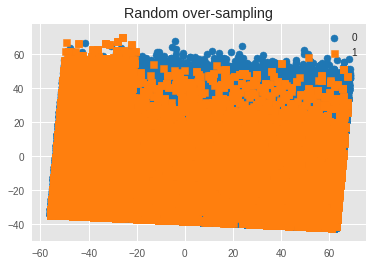

In [80]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler()
X_ros, y_ros = ros.fit_sample(train, y_train)

print(X_ros.shape[0] - train.shape[0], 'new random picked points')
print(len([i for i in y_train if i == 0 ] ))
print(len([i for i in y_train if i == 1 ] ))
print(len([i for i in y_ros if i == 0 ] ))
print(len([i for i in y_ros if i == 1 ] ))
plot_2d_space(X_ros, y_ros, 'Random over-sampling')


100670
43499
100670
100670


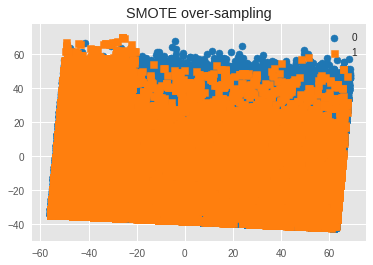

In [84]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(ratio='minority')
X_sm, y_sm = smote.fit_sample(train, y_train)
print(len([i for i in y_train if i == 0 ] ))
print(len([i for i in y_train if i == 1 ] ))
print(len([i for i in y_sm if i == 0 ] ))
print(len([i for i in y_sm if i == 1 ] ))
plot_2d_space(X_sm, y_sm, 'SMOTE over-sampling')

Apply Models on Sampling data

In [85]:
svm_model = SGDClassifier(n_iter=100, alpha=0.01) 
svm_model.fit(X_ros, y_ros)
y_pred = svm_model.predict(test)
print(classification_report(y_test, y_pred))

/home/sayali/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:73: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


             precision    recall  f1-score   support

          0       0.95      0.80      0.87     25152
          1       0.66      0.91      0.77     10891

avg / total       0.87      0.83      0.84     36043



In [86]:
svm_model = SGDClassifier(n_iter=100, alpha=0.01) 
svm_model.fit(X_rus, y_rus)
y_pred = svm_model.predict(test)
print(classification_report(y_test, y_pred))

/home/sayali/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:73: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


             precision    recall  f1-score   support

          0       0.95      0.80      0.87     25152
          1       0.66      0.91      0.77     10891

avg / total       0.87      0.83      0.84     36043



In [87]:
svm_model = SGDClassifier(n_iter=100, alpha=0.01) 
svm_model.fit(X_sm, y_sm)
y_pred = svm_model.predict(test)
print(classification_report(y_test, y_pred))

/home/sayali/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:73: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


             precision    recall  f1-score   support

          0       0.95      0.79      0.87     25152
          1       0.66      0.91      0.76     10891

avg / total       0.86      0.83      0.84     36043



## Final OutPut

We need predict Probablities

In [107]:
train, test, y_train, y_test = train_test_split(data, y, test_size=0.2)
new_var = ['Prescription_period','Age']
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(train[new_var], y_train)
y_pred = rf_model.predict(test[new_var])
y_pred_prob = rf_model.predict_proba(test[new_var])
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

         No       0.94      0.90      0.92     25218
        Yes       0.78      0.87      0.83     10825

avg / total       0.90      0.89      0.89     36043



In [111]:
prob = []
for i in range(len(y_pred)):
    if y_pred[i] == 'Yes':
        prob.append(y_pred_prob[i,1])
    elif y_pred[i] == 'No':
        prob.append(y_pred_prob[i,0])


In [115]:
from pandas.compat import OrderedDict
output_d = OrderedDict()
output_d['patient_id'] = test.patient_id
output_d['Adherence'] = y_pred
output_d['prob'] = prob
output = pd.DataFrame(output_d)
output.to_csv('./output.csv')
output.head()

,patient_id,Adherence,prob
153062,153062,No,1.000000
35569,35569,No,0.935675
138279,138279,No,1.000000
50461,50461,No,0.932130
45497,45497,No,1.000000


### To be Continued .....